# Carpet Color Classification

This notebook demonstrates the process for training a classifier to distinguish the four carpet colors in my office.

## Background

The overall aim is to develop a localisation system which keeps track of a robot's location based on the pattern of colors on the office floor. The carpet has four distinct colors - black, light blue, dark blue and beige, as seen below:

![Roomba on carpet](images/roomba_on_carpet.jpg)

Carpet color will be detected using a downward facing camera. A classifier will be used to determine which of the four colors are present in a given image. For the purpose of training , a dataset of images has already been collected in which all four colors are observed in sequence. The dataset was collected using `image_recorder` from this python package.

## Step one: visualise the dataset

Here we load dependenices and make a mosaic from a selection of the images in the dataset.

In [2]:
# dependencies for this notebook
import glob
from itertools import product
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture

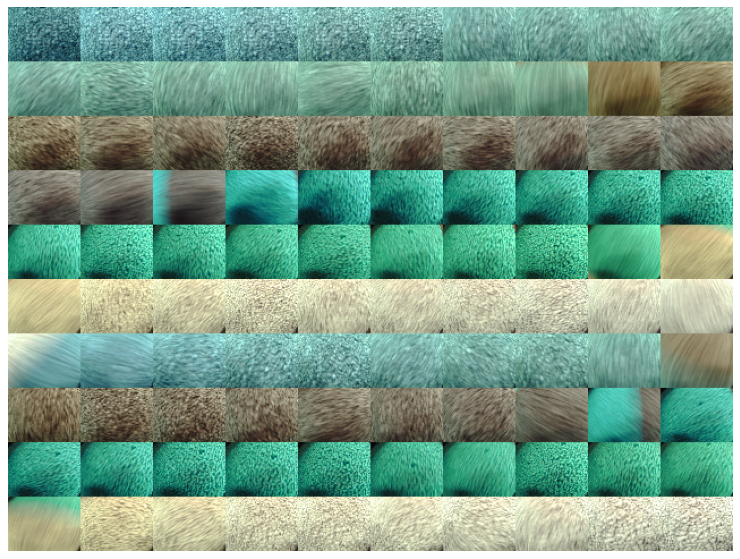

In [11]:
## visualise the dataset as a mosaic

dataset_dir = "/tmp/webcam_frames/"
image_paths = sorted(np.array(list(glob.iglob(f"{dataset_dir}/*.png"))))

# make a 10x10 mosaic of regularly sampled images from the dataset
sampled_image_paths = np.take(image_paths, np.linspace(0, len(image_paths)-1, num=100, dtype=np.int64))

mosaic = np.zeros((480, 640, 3), np.uint8)
for (i,j), image_path in zip(product(range(10), range(10)), sampled_image_paths):
    image = cv2.imread(image_path)
    thumbnail = cv2.resize(image, (64, 48))
    u_start = i*48
    v_start = j*64
    mosaic[u_start:u_start+48, v_start:v_start+64, :] = thumbnail

rgb_mosaic = cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB)
plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(rgb_mosaic)
plt.axis('off')
plt.show()

The above mosaic shows 100 images from the dataset, in time order (left-to-right then down).

The transition of colors is DARK_BLUE -> BLACK -> LIGHT_BLUE -> BEIGE -> DARK BLUE. The cycle repeats once.

## Step two: Extract features for classification

Rather than feed whole images into the classifier, the images are summarised by average color values, and these averages are used for classification. 

This section reads the full input dataset and computes and plots the per-image average color values.

I first had a look at using average RGB values per image as well as average HSV values.



In [12]:
# contruct a dataframe containing average rgb values per image
    
rgb_val_dicts = []
for image_path in image_paths:
    frame = cv2.imread(image_path)
    b,g,r = np.mean(frame, axis=(0,1))
    rgb_val_dicts.append(dict(r=r,g=g,b=b))

rgb_frame = pd.DataFrame(rgb_val_dicts)
rgb_frame.head()

,r,g,b
0,66.211911,118.178838,123.894977
1,26.507412,53.115169,59.753704
2,105.215518,164.151790,168.922669
3,105.262591,164.152402,168.919941
4,105.172367,163.883542,168.807298


In [15]:
# plot the rgb values together

# for plotting, define rbg color strings per datapoing
colors = []
for _,row in rgb_frame.iterrows():    
    color_str = f"rgb({int(row.r)},{int(row.g)},{int(row.b)})"
    colors.append(color_str)
    
data = go.Scatter3d(x=rgb_frame.r, y=rgb_frame.g, z=rgb_frame.b, mode="lines+markers", marker=dict(color=colors))
fig = go.Figure(data)
fig.update_layout(
    title="Average RGB values per image",
    scene=dict(
        xaxis_title='R',
        yaxis_title='G',
        zaxis_title='B',
    )
)
fig.show()

The above scatter plot shows each image as a point in R/G/B space, colored by the actual average RGB for that image. The lines show the sequence of time (sequential points are connected). From this we can see that two cycles through the colors were taken.

The points show good separation between the 4 color clusters, suggesting a cluster-based classifier should be able to distinguish the colors well.

Note that color separation is often performed in HSV space, using thresholds on the single 'hue' dimension (for example see [this opencv tutorial](https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html)). Out of interest I plot the image points in HSV space, to see if the clusters appear more separable:

In [16]:
# instead of rgb values, look at hsv
hsv_dicts = []
for _,row in rgb_frame.iterrows():
    rgb = np.uint8([[[int(row.r), int(row.g), int(row.b)]]])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)[0][0]
    hsv_dicts.append(dict(h=hsv[0], s=hsv[1], v=hsv[2]))

hsv_frame = pd.DataFrame(hsv_dicts)

data = go.Scatter3d(x=hsv_frame.h, y=hsv_frame.s, z=hsv_frame.v, mode="lines+markers", marker=dict(color=colors))
fig = go.Figure(data)
fig.update_layout(
    title="Average HSV values per image",
    scene=dict(
        xaxis_title='H',
        yaxis_title='S',
        zaxis_title='V',
    )
)
fig.show()

I'd say the clusters in the HSV plot appear slightly more spread out, so are perhaps easier to capture with a clustering algorithm, although I'm not sure there's a big difference. So I'll perform my clustering on HSV values.

## Step three: Fit a model

In order to automatically distinguish between the four color clusters, I've used a clustering algorithm to train a model.

My first thought was to try k-means (with k=4), however I wanted to capture the idea that clusters are spread out more in some dimensions than others. Some googling lead me to gaussian mixture models, which are well explained in [this blog post](https://docs.opencv.org/3.4/da/d97/tutorial_threshold_inRange.html).

The following fits a gaussian mixture model to the data:

In [26]:
# set seed for repeatability
np.random.seed(1234)

# fit the model and use it to label the dataset
gmm = GaussianMixture(n_components=4)
gmm.fit(hsv_frame)
labels = gmm.predict(hsv_frame)

# plot the labeled results
hsv_frame['cluster'] = labels
data = go.Scatter3d(x=hsv_frame.h, y=hsv_frame.s, z=hsv_frame.v, mode="lines+markers", marker=dict(color=labels))
fig = go.Figure(data)
fig.update_layout(
    title="Average HSV values per image, colored by GMM class",
    scene=dict(
        xaxis_title='H',
        yaxis_title='S',
        zaxis_title='V',
    )
)
fig.show()